In [60]:
# basics
import pandas as pd
import numpy as np
import collections

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# tools
import scipy
import math
import random
import sklearn
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')

# # handle from here
finalbooks = pd.read_csv('../../sample data/finalbooks.csv')
ratings = pd.read_csv('../../sample data/finalratings.csv')
train = pd.read_csv('../../sample data/train.csv')
test = pd.read_csv('../../sample data/test.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NITEESHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
## NDGC & RMSE

def dcg_k(r, k):
    """ Discounted Cumulative Gain (DGC)  
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        DCG
    """
  
    r = np.asfarray(r)[:k]
    return np.sum(2**r / np.log2(np.arange(2, r.size + 2)))      



def ndcg_k(r, k):
    """Normalized Discounted Cumulative Gain (NDCG)
    Args:
        r: True Ratings in Predicted Rank Order (1st element is top recommendation)
        k: Number of results to consider
    Returns:
        NDCG
    """
    dcg_max = dcg_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_k(r, k) / dcg_max

def mean_ndcg(rs):
    """Mean NDCG for all users
    Args:
        rs: Iterator / For each user: True Ratings in Predicted Rank Order
    Returns:
        Mean NDCG
    """
    return np.mean([ndcg_k(r, len(r)) for r in rs])

def rmse(y,h):
    """RMSE
    Args:
        y: real y
        h: predicted y
    Returns:
        RMSE
    """
    a = y-h

    return np.sqrt(sum(a**2)/len(a))

In [62]:
## DEFINING THE TAIL
tailcomp = ratings.groupby(by= 'newbookid', as_index=False).agg({'rating':pd.Series.count}).sort_values(by = 'rating', ascending = False)
tot = sum(tailcomp['rating'])
tailcomp['popshare']= [x/tot for x in tailcomp['rating']]
tailcomp['popshare']= tailcomp['popshare'].cumsum()
tailcomp['category']= ['Head' if x<0.95 else "Tail" for x in tailcomp['popshare']]

tail = tailcomp.loc[tailcomp.popshare >= 0.95]
tail

,newbookid,rating,popshare,category
837,838,48,0.950234,Tail
861,862,47,0.950630,Tail
720,721,47,0.951026,Tail
971,972,47,0.951422,Tail
783,784,47,0.951818,Tail
...,...,...,...,...
974,975,40,0.998652,Tail
600,601,40,0.998989,Tail
495,496,40,0.999326,Tail
399,400,40,0.999663,Tail


In [63]:
def get_words(message):
    """Get the normalized list of words from a message string.

    This function should split a message into words, normalize them, and return
    the resulting list. For splitting, you should split on spaces. For normalization,
    you should convert everything to lowercase.

    Args:
        message: A string containing an SMS message

    Returns:
       The list of normalized words from the message.
    """


    words = message
    words = words.split(" ")
    words = [x.lower() for x in words]

    return words



def create_dictionary(messages):
    """Create a dictionary mapping words to integer indices.

    Args:
        messages: A list of strings containing SMS messages

    Returns:
        A python dict mapping words to integers.
    """

    word_counts = collections.defaultdict(int)

    for message in messages:
        for word in set(get_words(message)):
            word_counts[word] += 1

    resulting_dictionary = {}

    for word, count in word_counts.items():
        if count >= 10 and word not in stopwords.words('english') and len(word) > 1:
            next_index = len(resulting_dictionary)
            resulting_dictionary[word] = next_index

    return resulting_dictionary


def transform_text(messages, word_dictionary):
    """Transform a list of text messages into a numpy array for further processing.

    Args:
        messages: A list of strings where each string is an SMS message.
        word_dictionary: A python dict mapping words to integers.

    Returns:
        A numpy array marking the words present in each message.
        Where the component (i,j) is the number of occurrences of the
        j-th vocabulary word in the i-th message.
    """

    A = np.zeros((len(messages), len(word_dictionary)))

    for i, message in enumerate(messages):
        for word in get_words(message):
            if word in word_dictionary:
                A[i, word_dictionary[word]] += 1

    return A

In [64]:
finalbooks['snippet'] = finalbooks['snippet'].fillna(finalbooks['title'])
finalbooks['snippet'] = finalbooks['snippet'].str.replace(r'[^\w\s]',"")
finalbooks['snippet'] = finalbooks['snippet'].str.replace('-',"")
finalbooks['tag_cloud'] = finalbooks['tag_cloud'].str.replace('-'," ")
finalbooks['snippet'] = finalbooks['snippet'].fillna(finalbooks['tag_cloud'])
finalbooks['words'] = finalbooks['snippet'] +" "+finalbooks['tag_cloud']+" "+finalbooks['first_author']
#finalbooks['words'] = finalbooks['snippet'] +" "+finalbooks['first_author']
dico = create_dictionary(finalbooks['words'])
dico

{'nature': 0,
 'star': 1,
 'lives': 2,
 'must': 3,
 'female': 4,
 'books|scifi': 5,
 'america': 6,
 'adult': 7,
 'known': 8,
 'losing': 9,
 'famous': 10,
 'power': 11,
 'sci': 12,
 'chosen': 13,
 'own|read': 14,
 'claim': 15,
 'ages': 16,
 'wealthy': 17,
 'destruction': 18,
 'young': 19,
 'books|own': 20,
 'favorites|ya': 21,
 'boy': 22,
 'time': 23,
 'read|all': 24,
 'second': 25,
 'make': 26,
 'leaving': 27,
 '2010|my': 28,
 'fight': 29,
 'means': 30,
 'creation': 31,
 'certain': 32,
 'close': 33,
 'take': 34,
 'history': 35,
 'country': 36,
 'girl': 37,
 'place': 38,
 'early': 39,
 'whole': 40,
 'forced': 41,
 'fi': 42,
 'nation': 43,
 'fiction|ya': 44,
 'sees': 45,
 'own|sci': 46,
 'lit|ya': 47,
 'grace': 48,
 'led': 49,
 'reading|young': 50,
 'survival': 51,
 'death': 52,
 'fiction|books': 53,
 'books|the': 54,
 'sister': 55,
 'north': 56,
 'fantasy|ya': 57,
 'one': 58,
 'read|childhood': 59,
 'fantasy|children': 60,
 'fantasy|read': 61,
 'books|my': 62,
 'harry': 63,
 'rowling': 

In [65]:
len(dico)

1883

In [66]:
A = transform_text(finalbooks['words'], dico)

In [67]:
np.size(A, 0)

1000

In [68]:
np.sum(A, axis=1).min()

10.0

In [69]:
A1 = np.sum((A>0), axis= 0)

IDF = np.log(np.size(A, 0)/A1)
IDF
len(IDF)

1883

In [70]:
TF = A / (np.sum(A, axis=1, keepdims=True))
np.shape(TF)

(1000, 1883)

In [71]:
TFiDF= TF*IDF
np.shape(TFiDF)

(1000, 1883)

In [72]:
#ids = np.argsort(TFiDF.mean(axis=1))[:5]
#reverse_dictionary = {i: word for word, i in dico.items()}
#[reverse_dictionary[i] for i in ids]

In [73]:
TFiDF = TFiDF / np.sqrt((np.sum(TFiDF**2, axis = 1, keepdims=True)+0.01))

In [74]:
SimC = np.dot(TFiDF, TFiDF.T)

In [75]:
SimC

array([[9.51098934e-01, 6.78417138e-02, 1.39094525e-02, ...,
        2.96461751e-02, 9.22480151e-03, 3.18550089e-02],
       [6.78417138e-02, 9.85989293e-01, 2.29048398e-02, ...,
        5.52441316e-02, 8.22436549e-04, 1.76153032e-02],
       [1.39094525e-02, 2.29048398e-02, 9.65569662e-01, ...,
        1.69400871e-02, 8.17997880e-03, 2.15112529e-02],
       ...,
       [2.96461751e-02, 5.52441316e-02, 1.69400871e-02, ...,
        9.27202645e-01, 3.03101249e-02, 5.31741353e-02],
       [9.22480151e-03, 8.22436549e-04, 8.17997880e-03, ...,
        3.03101249e-02, 9.61875299e-01, 3.01767272e-02],
       [3.18550089e-02, 1.76153032e-02, 2.15112529e-02, ...,
        5.31741353e-02, 3.01767272e-02, 9.32594897e-01]])

In [76]:
np.sum(SimC, axis = 1).max()

52.2837314533282

In [77]:
np.fill_diagonal(SimC, 1)

In [78]:
SimC

array([[1.00000000e+00, 6.78417138e-02, 1.39094525e-02, ...,
        2.96461751e-02, 9.22480151e-03, 3.18550089e-02],
       [6.78417138e-02, 1.00000000e+00, 2.29048398e-02, ...,
        5.52441316e-02, 8.22436549e-04, 1.76153032e-02],
       [1.39094525e-02, 2.29048398e-02, 1.00000000e+00, ...,
        1.69400871e-02, 8.17997880e-03, 2.15112529e-02],
       ...,
       [2.96461751e-02, 5.52441316e-02, 1.69400871e-02, ...,
        1.00000000e+00, 3.03101249e-02, 5.31741353e-02],
       [9.22480151e-03, 8.22436549e-04, 8.17997880e-03, ...,
        3.03101249e-02, 1.00000000e+00, 3.01767272e-02],
       [3.18550089e-02, 1.76153032e-02, 2.15112529e-02, ...,
        5.31741353e-02, 3.01767272e-02, 1.00000000e+00]])

In [79]:
BookSim =pd.DataFrame(SimC, columns=finalbooks.title, index=finalbooks.title)

In [80]:
#np.argsort(SimC[53, :])[-5:]
finalbooks.title[np.argsort(SimC[15, :])[-6:]]
#Sim20 = pd.DataFrame(Sim20, columns=finalbooks.title[101:200], index=finalbooks.title[50:60])

493        The Way of Kings (The Stormlight Archive, #1)
605                                           The Reader
656                               No Country for Old Men
500              Men Are from Mars, Women Are from Venus
138    The Girl Who Kicked the Hornet's Nest (Millenn...
15      The Girl with the Dragon Tattoo (Millennium, #1)
Name: title, dtype: object

In [81]:
#SimC[15, [15, 2252, 6977, 4642, 2796, 1700 ]]

In [82]:
finalbooks [finalbooks.newbookid.isin(np.argsort(SimC[15, :])[-6:]+1)]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_5,image_url,small_image_url,newbookid,tag_cloud,mosttagged,snippet,pages,first_author,words
15,16,2429135,2429135,1708725,274,307269752,9.780307e+12,"Stieg Larsson, Reg Keeland",2005.0,Män som hatar kvinnor,...,836050,https://images.gr-assets.com/books/1327868566m...,https://images.gr-assets.com/books/1327868566s...,16,to read|currently reading|fiction|mystery|favo...,to-read,Mikael Blomkvist ekonomireporter döms till fän...,566 pages,Stieg Larsson,Mikael Blomkvist ekonomireporter döms till fän...
138,140,6892870,6892870,12883496,193,030726999X,9.780307e+12,"Stieg Larsson, Reg Keeland",2007.0,Luftslottet som sprängdes,...,226511,https://images.gr-assets.com/books/1327708260m...,https://images.gr-assets.com/books/1327708260s...,139,to read|currently reading|fiction|mystery|favo...,to-read,The Girl Who Kicked the Hornets Nest Millennium 3,0,Stieg Larsson,The Girl Who Kicked the Hornets Nest Millenniu...
493,562,7235533,7235533,8134945,48,765326353,9.780765e+12,Brandon Sanderson,2010.0,The Way of Kings,...,119942,https://images.gr-assets.com/books/1388184640m...,https://images.gr-assets.com/books/1388184640s...,494,to read|fantasy|currently reading|favorites|fi...,to-read,From 1 New York Times bestselling author Brand...,1007 pages,Brandon Sanderson,From 1 New York Times bestselling author Brand...
500,573,1274,1274,55001,202,60574216,9.780061e+12,John Gray,1998.0,"Men Are from Mars, Women Are from Venus Book o...",...,31104,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,501,to read|currently reading|non fiction|self hel...,to-read,Once upon a time Martians and Venusians met fe...,368 pages,John Gray,Once upon a time Martians and Venusians met fe...
605,727,101299,101299,23684,183,375408266,9.780375e+12,"Bernhard Schlink, Carol Brown Janeway",1995.0,Der Vorleser,...,32414,https://images.gr-assets.com/books/1327936339m...,https://images.gr-assets.com/books/1327936339s...,606,to read|fiction|historical fiction|currently r...,to-read,Sie ist reizbar rätselhaft und viel älter als ...,216 pages,Bernhard Schlink,Sie ist reizbar rätselhaft und viel älter als ...
656,815,12497,12497,2996445,104,375706674,9.780376e+12,Cormac McCarthy,2005.0,No Country for Old Men,...,42660,https://images.gr-assets.com/books/1443231179m...,https://images.gr-assets.com/books/1443231179s...,657,to read|favorites|fiction|currently reading|th...,to-read,In his blistering new novel Cormac McCarthy re...,309 pages,Cormac McCarthy,In his blistering new novel Cormac McCarthy re...


KeyboardInterrupt: 

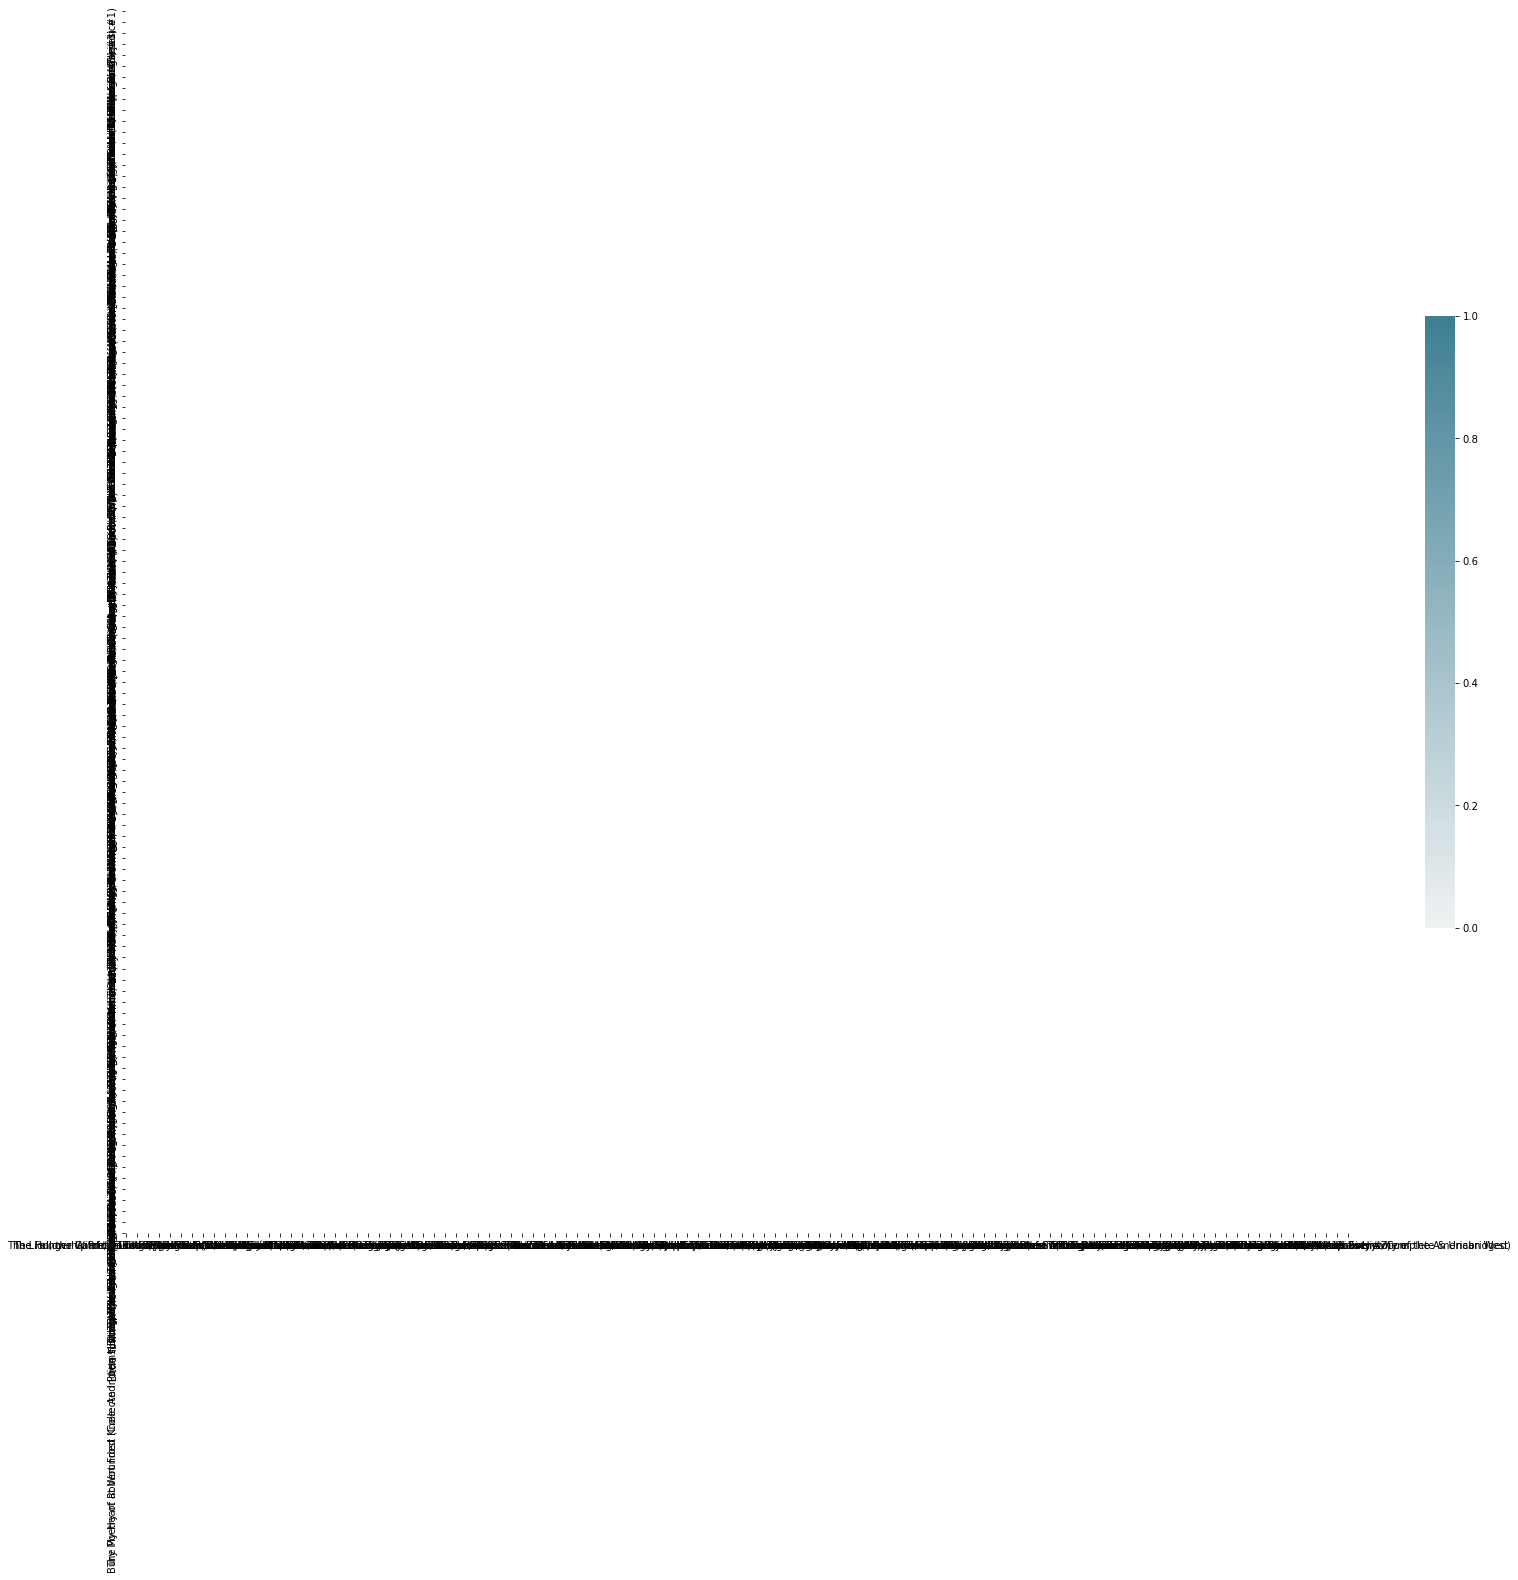

In [25]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(27.5, 22.5))

# Generate a custom diverging colormap followed by the correlation heatmap
cmap =sns.diverging_palette(20, 220, n=20000)

sns.heatmap(BookSim, cmap=cmap,center = 0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
train

,rating,newbookid,newuser_id
0,4,552,377
1,3,488,104
2,4,542,601
3,4,52,236
4,3,147,736
...,...,...,...
94935,5,413,30
94936,4,125,987
94937,3,930,886
94938,3,509,269


In [83]:
allpreds = []
train = train.sort_values(by=['newbookid'])
b = pd.DataFrame({'newbookid':pd.Series([], dtype='int64'), 'newuser_id':pd.Series([], dtype='int64'), 'pred':pd.Series([], dtype='float64')})
b.to_csv('tf.csv',index=False)

for i in range(15000):
  bi = train.newbookid[train.newuser_id == i+1]-1
  Simi = SimC[:, bi]
  ri = np.array(train[train.newuser_id == i+1].sort_values(by=['newbookid']).rating)
  predi = finalbooks.filter(['newbookid'])
  predi['pred'] = np.sum(Simi*ri, axis=1)/(np.sum(Simi, axis=1)+0.01)
  predi['newuser_id'] = i+1
  predi.to_csv('tf.csv', mode = 'a', header = False, index=False)
  #allpreds.append(predi)
  if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [84]:
import time
from dask import dataframe as dd
start = time.time()
final = dd.read_csv('tf.csv')
#final.astype({'newuser_id': 'int64'}).dtypes
end = time.time()
print("Read csv with dask in: ",(end-start),"sec")
final['newuser_id'] = final['newuser_id'].astype('int64')
final['pred'] = final['pred'].astype('float64')
final

Read csv with dask in:  0.04046297073364258 sec


,newbookid,newuser_id,pred
npartitions=4,,,
,int64,int64,float64
,...,...,...
,...,...,...
,...,...,...
,...,...,...


In [85]:
#predictions = np.concatenate(allpreds, axis=0)

In [86]:
#final =pd.DataFrame(predictions, columns=['newbookid', 'pred', 'newuser_id'])

In [87]:
train['conc']=train['newuser_id'].map(str)+train['newbookid'].map(str)
final['conc']=final['newuser_id'].map(str)+final['newbookid'].map(str)
finalfin = final[~final.conc.isin(train.conc)]
finalfin.describe()

,newbookid,newuser_id,pred
npartitions=1,,,
,float64,float64,float64
,...,...,...


In [88]:
test = dd.read_csv('../../sample data/test.csv')
test

,rating,newbookid,newuser_id
npartitions=1,,,
,int64,int64,int64
,...,...,...


In [89]:
train = dd.read_csv('../../sample data/train.csv')
train

,rating,newbookid,newuser_id
npartitions=1,,,
,int64,int64,int64
,...,...,...


In [90]:
finalrank = test.merge(final,on = ['newbookid', 'newuser_id'])
#finalrank = finalrank.sort_values(by=['newuser_id', 'pred'], ascending=False)
finalrank = finalrank.map_partitions(lambda x: x.sort_values(by=['newuser_id', 'pred']))
finalrank.head(5)

,rating,newbookid,newuser_id,pred,conc
1695,4,437,1,353.0,1437
1696,4,437,1,537.0,1437
1699,4,311,1,537.0,1311
2707,3,679,1,537.0,1679
4723,3,780,1,537.0,1780


In [91]:
finallist = []
for i in range(15000):
    a = finalrank.loc[finalrank.newuser_id == i+1]['rating'].values #changed tolist()
    finallist.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [ ]:
b = np.array([ndcg_k(r, len(r)) for r in finallist])


facet, axes = plt.subplots(1, 1, figsize=(10, 3))
n, bins, patches = plt.hist(b, 200, facecolor='blue', alpha=0.5) #, log = True)   
plt.title('Distribution of NDGC among Users for the TFiDF model')
plt.show()

# [ndcg_k(r, len(r)) for r in poplista]

In [ ]:
d = b[b == 1]
sum(d)/15000

In [92]:
top10 = finalfin.sort_values('pred',ascending = False).groupby('newuser_id').head(10)
top50 = finalfin.sort_values('pred',ascending = False).groupby('newuser_id').head(50)

print('(1) TF-iDF Model RMSE: ', np.round(rmse(finalrank['pred'],finalrank['rating']), decimals=3))
print('(2) TF-iDF Model NDCG: ', np.round(mean_ndcg(finallist), decimals=3))
print("(2) Median NDCG: ", np.round(np.median(b), decimals=3))
print("(2) Share of NDCG =1 among Users: ", np.round(sum(d)/15000, decimals=3))
print('(3) TF-iDF Model Div10 Score: ',np.round(sum(np.in1d(top10.newbookid, tail.newbookid))/len(top10), decimals=3))
print('(3) TF-iDF Model Div50 Score: ',np.round(sum(np.in1d(top50.newbookid, tail.newbookid))/len(top50), decimals=3))

AttributeError: 'DataFrame' object has no attribute 'sort_values'

In [ ]:
finalranktrain = train.merge(final,on = ['newbookid', 'newuser_id'])
finalranktrain = finalranktrain.sort_values(by=['newuser_id', 'pred'], ascending=False)

In [ ]:
finalranktrain

In [93]:
finallisttrain = []
for i in range(15000):
    a = finalranktrain.loc[finalranktrain.newuser_id == i+1]['rating'].values #changed tolist()
    finallisttrain.append(a)
    if (i+1)%1000 == 0: print("done: ", i+1)

done:  1000
done:  2000
done:  3000
done:  4000
done:  5000
done:  6000
done:  7000
done:  8000
done:  9000
done:  10000
done:  11000
done:  12000
done:  13000
done:  14000
done:  15000


In [94]:
print('(1) TF-iDF Train Model RMSE: ', np.round(rmse(finalranktrain['pred'],finalranktrain['rating']), decimals=3))
print('(2) TF-iDF Train Model NDCG: ', np.round(mean_ndcg(finallisttrain), decimals=3))

KeyboardInterrupt: 